In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np
from Bio.PDB.vectors import Vector
from Bio.PDB.vectors import calc_dihedral
from collections import defaultdict
import random
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


In [2]:
#compiled code for model1 
#k-nearest neighbors; k = 3 - approach 2 


def normalize_column(df):
    max_df=max(df['G_kcal'])
    min_df=min(df['G_kcal'])
    df['nor_delG']=df['G_kcal'].apply(lambda x: (x-min_df)/(max_df-min_df))
    #df['label_delG']=df['nor_delG'].apply(lambda x: 1 if x<0.33 else ( 2 if x < 0.66 else 3))
    df['label_delG']=df['nor_delG'].apply(lambda x: 1 if x<0.2 else 0)
    return df 

def pre_processing(filename):
    df=pd.read_csv(filename)
    app_df= df[df['rotamer']=='app']
    exo_df= df[df['rotamer']=='syn_exo']
    endo_df= df[df['rotamer']=='syn_endo']

    nor_app_df=normalize_column(app_df)
    nor_exo_df=normalize_column(exo_df)
    nor_endo_df=normalize_column(endo_df)
    norm_df=pd.concat([nor_exo_df,nor_endo_df, nor_app_df])
    
    features=list(zip(norm_df.value1,norm_df.value2,norm_df.value3,norm_df.value4))
    label= list(norm_df.label_delG)
    
    return features, label, norm_df


OTDS_simple=pre_processing('/Users/chingchinglam/Desktop/iminium/ring-out.csv')

otds_feature=OTDS_simple[0]
otds_label=OTDS_simple[1]
otds_df=OTDS_simple[2]

model1 = KNeighborsClassifier(n_neighbors=3)
model1.fit(otds_feature, otds_label)

###################

def dihedral_angle_value(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    return di_angle

#find the dihedral angle value functions compiles 
def dihedral_angle_value_com(structure_xyz,atom_list):
    
    atom_of_interest=atom_of_interst_formating(structure_xyz,atom_list)

    atom_of_interest_sort=sort_list(atom_list,atom_of_interest)
    
    result = dihedral_angle_value(atom_of_interest_sort)
    
    return result 


<ipython-input-2-fa3971960e28>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nor_delG']=df['G_kcal'].apply(lambda x: (x-min_df)/(max_df-min_df))
<ipython-input-2-fa3971960e28>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_delG']=df['nor_delG'].apply(lambda x: 1 if x<0.2 else 0)


In [8]:
def parse_line(number, string):
    stringa=string.split() 

    for index in range(1, 4):
        stringa[index] = float(stringa[index])

    lista = [number]+[stringa[0]]+[stringa[1:4]]
    
    return lista

#parse_line(1, 'C          1.07360        2.08400        2.15270')



###################

#calculate the dihedral angle - from biopython package 
def dihedral_angle(list_A1, list_A2, list_B1, list_B2):


    a = Vector(list_A1[0]   ,list_A1[1] , list_A1[2]) 
    b = Vector(list_A2[0]   ,list_A2[1] , list_A2[2]) 
    c = Vector(list_B1[0]   ,list_B1[1] , list_B1[2]) 
    d = Vector(list_B2[0]   ,list_B2[1] , list_B2[2])

    di_angle = calc_dihedral(a,b,c,d)* 180.0/pi
    
    return di_angle


##########

#categorize torsional conformers by dihedral angle 
def is_syn_app(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    if di_angle >0 and di_angle <100:
        return 'syn_exo'
    elif di_angle == 0:
        return 'syn_exo'
    elif di_angle <0 and di_angle > -100:
        return 'syn_endo'
    else:
        return 'app'

#this should be rename is_E_Z: tell E/Z by dihedral angle 
def is_cis_trans(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    if di_angle <90 and di_angle > -90:
        return 'Z'
    elif di_angle == 0:
        return 'Z'
    else:
        return 'E'

#new - pointing towards or away from the large R group 
    
def is_in_out(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    
    result ='out'
    if di_angle < 90 and di_angle > -90:
        result ='in'
    
    return result


def retur_di(atom_of_interest):
    list1=atom_of_interest[0]
    list2=atom_of_interest[1]
    list3=atom_of_interest[2]
    list4=atom_of_interest[3]
    di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
    return di_angle
    
    
def is_para_per(atom_of_interest0,atom_of_interest1,atom_of_interest2,atom_of_interest3):

    
    di_angle0= retur_di(atom_of_interest0)
    di_angle1= retur_di(atom_of_interest1)
    di_angle2= retur_di(atom_of_interest2)
    di_angle3= retur_di(atom_of_interest3)
    
    di_list = [di_angle0,di_angle1,di_angle2,di_angle3]

    
    result='para'
    for i in di_list:
        if i > 60 and i < 110:
            result='per'
        elif i > -110 and i < -60:
            result='per'

    return result
    
    
#################
#ring dectection code 


#possibility generation function - no. of dihedral angles possible within a 5 member ring 

def possibility_generation(atom_list,atom_of_interest):
    atom1_a=atom_list[0].split(' ')
    atom1_b=atom_list[1].split(' ')
    atom1_c=atom_list[2].split(' ')
    atom1_d=atom_list[3].split(' ')
    atom1_e=atom_list[4].split(' ')
    
    number_list = [[1,int(atom1_a[1])], [2,int(atom1_b[1])], [3,int(atom1_c[1])], 
                   [4,int(atom1_d[1])],  [5,int(atom1_e[1])]]
    new=sorted(number_list, key = lambda x: x[1])
    new_list=[i[0] for i in new]

    zipped_lists = zip(new_list, atom_of_interest)

    sorted_zipped_lists = sorted(zipped_lists)

    sorted_list= [element for _, element in sorted_zipped_lists]
    
    N1 = sorted_list[1:]
    C2 = sorted_list[2:]+[sorted_list[0]]
    C3 = sorted_list[3:] +sorted_list[0:2]
    C4 = [sorted_list[-1]] + sorted_list[0:3]
    C5 = sorted_list[0:-1]
    
    possibility_list = [N1, C2, C3, C4, C5]
    
    return possibility_list


# calculate the dihedral angel and generate the result list 
# 0 = twist ring, 1-5=envelope (the number refer to the position of the endo atom)

def what_ring_type(possibility_coor):

    di_angle_result=[]

    for coor_list in possibility_coor:
        list1=coor_list[0]
        list2=coor_list[1]
        list3=coor_list[2]
        list4=coor_list[3]
        di_angle= dihedral_angle(list1[2], list2[2],list3[2], list4[2])
        di_angle_result.append(di_angle)

    #print(di_angle_result)
    di_angle_result_ab = list(np.absolute(di_angle_result))
    #print(di_angle_result_ab)
    
    min_position=di_angle_result_ab.index(min(di_angle_result_ab))

    if di_angle_result_ab[min_position]<10: 
        endo_position=min_position+1
    else: 
        endo_position=0
    
    return endo_position


################### compile ring detection code 


def dihedral_angle_test_ring_version(structure_xyz,atom_list1):
    parse_line_list=[]
    atom_of_interest1=[]
    
    atom1_a=atom_list1[0].split(' ')
    atom1_b=atom_list1[1].split(' ')
    atom1_c=atom_list1[2].split(' ')
    atom1_d=atom_list1[3].split(' ')
    atom1_e=atom_list1[4].split(' ')
    
    
    for i in structure_xyz:
        number=structure_xyz.index(i)
        parse_line_list.append(parse_line(number+1, i))
        #print(parse_line_list)

    for j in parse_line_list:
        if j[1] == atom1_a[0] and j[0] == int(atom1_a[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_b[0] and j[0] == int(atom1_b[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_c[0] and j[0] == int(atom1_c[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_d[0] and j[0] == int(atom1_d[1]):
            atom_of_interest1.append(j)
        elif j[1] == atom1_e[0] and j[0] == int(atom1_e[1]):
            atom_of_interest1.append(j)
    
    
    possibility_coor1 = possibility_generation(atom_list1,atom_of_interest1)
    result = what_ring_type(possibility_coor1)
    
    return result 
    
    
#################
    
    
    
def sort_list(atom_list,atom_of_interest):
    atom1_a=atom_list[0].split(' ')
    atom1_b=atom_list[1].split(' ')
    atom1_c=atom_list[2].split(' ')
    atom1_d=atom_list[3].split(' ')
    
    number_list = [[1,int(atom1_a[1])], [2,int(atom1_b[1])], [3,int(atom1_c[1])], [4,int(atom1_d[1])]]
    new=sorted(number_list, key = lambda x: x[1])
    new_list=[i[0] for i in new]
    
    zipped_lists = zip(new_list, atom_of_interest)

    sorted_zipped_lists = sorted(zipped_lists)


    sorted_list1 = [element for _, element in sorted_zipped_lists]
    
    return sorted_list1

#intergrating dihedral_angle_test(structure_xyz,atom_list1) function here 
#if there's error, you need to check both function


def atom_of_interst_formating(structure_xyz,atom_list):
    parse_line_list=[]
    atom_of_interest=[]
    
    atom1_a=atom_list[0].split(' ')
    atom1_b=atom_list[1].split(' ')
    atom1_c=atom_list[2].split(' ')
    atom1_d=atom_list[3].split(' ')
    
        #formating according with parse_line function
    for i in structure_xyz:
        number=structure_xyz.index(i)
        parse_line_list.append(parse_line(number+1, i))
        #print(parse_line_list)
        
    #append parse_line of atoms from the input atom_lists to atom_of_interest list 
    for j in parse_line_list:
        if j[1] == atom1_a[0] and j[0] == int(atom1_a[1]):
            atom_of_interest.append(j)
        elif j[1] == atom1_b[0] and j[0] == int(atom1_b[1]):
            atom_of_interest.append(j)
        elif j[1] == atom1_c[0] and j[0] == int(atom1_c[1]):
            atom_of_interest.append(j)
        elif j[1] == atom1_d[0] and j[0] == int(atom1_d[1]):
            atom_of_interest.append(j)
    
    return atom_of_interest
    
    
def dihedral_angle_test(structure_xyz,atom_list1, atom_list2, atom_list3, atom_list4, atom_list5, atom_list6, atom_list7, atom_list8,atom_list9):

    
    atom_of_interest1=atom_of_interst_formating(structure_xyz,atom_list1)
    atom_of_interest2=atom_of_interst_formating(structure_xyz,atom_list2)
    atom_of_interest4=atom_of_interst_formating(structure_xyz,atom_list4)
    atom_of_interest5=atom_of_interst_formating(structure_xyz,atom_list5)
    atom_of_interest6=atom_of_interst_formating(structure_xyz,atom_list6)
    atom_of_interest7=atom_of_interst_formating(structure_xyz,atom_list7)
    atom_of_interest8=atom_of_interst_formating(structure_xyz,atom_list8)
    atom_of_interest9=atom_of_interst_formating(structure_xyz,atom_list9)

    
    atom_of_interest1_sort=sort_list(atom_list1,atom_of_interest1)
    atom_of_interest2_sort=sort_list(atom_list2,atom_of_interest2)
    atom_of_interest4_sort=sort_list(atom_list4,atom_of_interest4)
    atom_of_interest5_sort=sort_list(atom_list5,atom_of_interest5)
    atom_of_interest6_sort=sort_list(atom_list6,atom_of_interest6)
    atom_of_interest7_sort=sort_list(atom_list7,atom_of_interest7)
    atom_of_interest8_sort=sort_list(atom_list8,atom_of_interest8)
    atom_of_interest9_sort=sort_list(atom_list9,atom_of_interest9)

    
    ring_dectection = dihedral_angle_test_ring_version(structure_xyz,atom_list3)
    
    result = [is_syn_app(atom_of_interest1_sort) + ' ' + is_cis_trans(atom_of_interest2_sort) + is_cis_trans(atom_of_interest9_sort) +  ' '+ str(ring_dectection)+' '+
              is_in_out(atom_of_interest4_sort)+ ' '+is_para_per(atom_of_interest5_sort, atom_of_interest6_sort, atom_of_interest7_sort, atom_of_interest8_sort)]
    
    # structural features can be introduced or removed from the conformation label by editting the line above 
    
    
    return result 

    

############################################
    #convert xyz file spacing to gjf spacing 
    
def right_spacing(coor_list):
    coor_list_space=[]
    for cline in coor_list:
        split_coor=cline.split()
        new_coor=''
        space1=18
        space2=4
        space3=4
        if len(split_coor[0]) == 2:
            space1=17
        for o in split_coor:  
            if '-' in o:
                index_list=[]
                index_list.append(split_coor.index(o))
                if 1 in index_list:
                    space1=17
                elif 2 in index_list:
                    space2=3
                elif 3 in index_list:
                    space3=3
        new_coor=str(split_coor[0])+space1*' '+str(split_coor[1])+'000'+space2*' '+str(split_coor[2])+'000'+space3*' '+str(split_coor[3])+'000\n'
        coor_list_space.append(new_coor)
    return coor_list_space





############# post processing 
#Index of duplicates items in a python list from 
#https://stackoverflow.com/questions/5419204/index-of-duplicates-items-in-a-python-list

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)  
    
    return [[key,locs] for key,locs in tally.items() if len(locs)>0]


def lengths(x):
    length_list=[]
    for u in x: 
        length_list.append(len(u[1]))
    length_list.sort(reverse=True)
    return length_list

def print_graphs(list_duplicates_result):
    data1=[]
    x_axis=[]
    for dup in list_duplicates_result:
        data1.append(len(dup[1]))
        x_axis.append(str(dup[0]))
        
    data = {'cate': x_axis, 'total': data1}
    df = pd.DataFrame(data)
    df.sort_values('total', axis = 0, ascending = False, inplace = True)
    
    print(df)
    plt.bar(df['cate'], df['total'])
    plt.xticks(rotation= 90)
    plt.show()
    

In [9]:
#xyz file as input 
def category_dih_angle(goodvibes_file, atom_list1, atom_list2, atom_list3, atom_list4, atom_list5,atom_list6, atom_list7, atom_list8,
                      atom_list9,atom_list10, atom_list11, atom_list12,atom_list13):
    
    #open the xyz file from goodvibes and transfer all the lines into a list 

    xyz_output=[]

    with open(goodvibes_file) as output:
        for line in output:
            xyz_output+= [line]

    #Find the index of line that contains 'Eopt'. These lines always appear above the xyz coordinate of a structure.
    #These lines also contains the filename of the .log files. 
    
    Eopt_index_list =[i+1 for i,d in enumerate(xyz_output) if len(d)<5]
    
    Eopt_list=[]
    for i in Eopt_index_list:
        Eopt_list.append(xyz_output[i])
    

    #Find the number of structures in the .xyz file from goodvibes 
    structure_number = len(Eopt_index_list)

    #split the xyz coordinates of structures into list -- [[structure1],[structure2]...]
    division1=[]
    for j in range(0,len(Eopt_index_list)):
        try:
            a=xyz_output[Eopt_index_list[j]+1: Eopt_index_list[j+1]-1]
            division1.append(a)
        except IndexError:
            b=xyz_output[Eopt_index_list[j]+1:]
            division1.append(b)

    #The filename are extracted into a list from Eopt_list
    filename=[]
    for indv in Eopt_list:
        filename_list=indv.split()
        filename.append(filename_list[0])
    
    division2=[]

    for s in division1:
        division2.append(right_spacing(s))
        
    con_label=[]
    value1 =[]
    value2 =[]
    value3 =[]
    value4 =[]

    for st in division2:
        output=dihedral_angle_test(st,atom_list1, atom_list2, atom_list3, atom_list4, atom_list5, atom_list6, atom_list7, atom_list8, atom_list9)
        con_label.append(output[0])
        
        output1=dihedral_angle_value_com(st,atom_list10)
        output2=dihedral_angle_value_com(st,atom_list11)
        output3=dihedral_angle_value_com(st,atom_list12)
        output4=dihedral_angle_value_com(st,atom_list13)
        value1.append(output1)
        value2.append(output2)
        value3.append(output3)
        value4.append(output4)
    
    #k-nearest neighbors test 
    
    feature=list(zip(value1,value2,value3,value4))
    prediction=model1.predict(feature)
    
    comb_label=[]
    for ind in range(0,len(prediction)):
        comb_label.append( con_label[ind]+' '+str(prediction[ind]))
    
        
    result = list_duplicates(comb_label) 
    
    print_graphs(result)

    filename_num=[]
    EZ=[]
    for k in filename:
        num=k.split('_')
        u=num[-2]
        EZ_l=num[-3]
        filename_num.append(int(u))
        EZ.append(EZ_l)

    dict_result= {'filename':filename, 'no':filename_num,'diene':EZ,'label_dft':comb_label}
    df = pd.DataFrame(dict_result)
    df.sort_values('no', axis = 0, ascending = True, inplace = True)
    
    return df
    #df.sort_values('diene', axis = 0, ascending = True, inplace = True)


In [10]:
#xyz file as input 
def category_dih_angle_noOTDS(goodvibes_file, atom_list1, atom_list2, atom_list3, atom_list4, atom_list5,atom_list6, atom_list7, atom_list8,
                      atom_list9):
    
    #open the xyz file from goodvibes and transfer all the lines into a list 

    xyz_output=[]

    with open(goodvibes_file) as output:
        for line in output:
            xyz_output+= [line]

    #Find the index of line that contains 'Eopt'. These lines always appear above the xyz coordinate of a structure.
    #These lines also contains the filename of the .log files. 
    
    Eopt_index_list =[i+1 for i,d in enumerate(xyz_output) if len(d)<5]
    
    Eopt_list=[]
    for i in Eopt_index_list:
        Eopt_list.append(xyz_output[i])
    

    #Find the number of structures in the .xyz file from goodvibes 
    structure_number = len(Eopt_index_list)

    #split the xyz coordinates of structures into list -- [[structure1],[structure2]...]
    division1=[]
    for j in range(0,len(Eopt_index_list)):
        try:
            a=xyz_output[Eopt_index_list[j]+1: Eopt_index_list[j+1]-1]
            division1.append(a)
        except IndexError:
            b=xyz_output[Eopt_index_list[j]+1:]
            division1.append(b)

    #The filename are extracted into a list from Eopt_list
    filename=[]
    for indv in Eopt_list:
        filename_list=indv.split()
        filename.append(filename_list[0])
    
    division2=[]

    for s in division1:
        division2.append(right_spacing(s))
        
    con_label=[]
    value1 =[]
    value2 =[]
    value3 =[]
    value4 =[]

    for st in division2:
        output=dihedral_angle_test(st,atom_list1, atom_list2, atom_list3, atom_list4, atom_list5, atom_list6, atom_list7, atom_list8, atom_list9)
        con_label.append(output[0])
        
        #output1=dihedral_angle_value_com(st,atom_list10)
        #output2=dihedral_angle_value_com(st,atom_list11)
        #output3=dihedral_angle_value_com(st,atom_list12)
        #output4=dihedral_angle_value_com(st,atom_list13)
        #value1.append(output1)
        #value2.append(output2)
        #value3.append(output3)
        #value4.append(output4)
    
    #k-nearest neighbors test 
    
    #feature=list(zip(value1,value2,value3,value4))
    #prediction=model1.predict(feature)
    
    #comb_label=[]
    #for ind in range(0,len(prediction)):
     #   comb_label.append( con_label[ind]+' '+str(prediction[ind]))
    
        
    result = list_duplicates(con_label) 
    
    print_graphs(result)

    filename_num=[]
    EZ=[]
    for k in filename:
        num=k.split('_')
        u=num[-2]
        EZ_l=num[-3]
        filename_num.append(int(u))
        EZ.append(EZ_l)

    dict_result= {'filename':filename, 'no':filename_num,'diene':EZ,'label_dft':con_label}
    df = pd.DataFrame(dict_result)
    df.sort_values('no', axis = 0, ascending = True, inplace = True)
    
    return df
    #df.sort_values('diene', axis = 0, ascending = True, inplace = True)

                      cate  total
6        app EZ 4 in per 1      2
0   syn_endo EZ 5 in per 0      1
1       app EE 3 out per 0      1
2        app EZ 3 in per 0      1
3        app EZ 4 in per 0      1
4       app EE 4 out per 0      1
5   syn_exo EE 4 out per 1      1
7        app EZ 3 in per 1      1
8       app EE 4 out per 1      1
9    syn_exo EZ 4 in per 0      1
10  syn_exo EE 4 out per 0      1


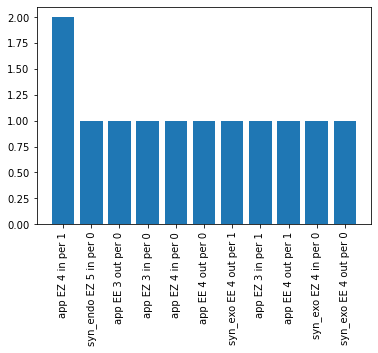

,filename,no,diene,label_dft
1,C_Me_RMe_R_139_TS,139,R,app EE 3 out per 0
11,C_Me_RMe_R_577_TS,577,R,syn_exo EE 4 out per 0
0,C_Me_RMe_R_1242_TS,1242,R,syn_endo EZ 5 in per 0
2,C_Me_RMe_R_1801_TS,1801,R,app EZ 3 in per 0
3,C_Me_RMe_R_1805_TS,1805,R,app EZ 4 in per 0
4,C_Me_RMe_R_1806_TS,1806,R,app EE 4 out per 0
5,C_Me_RMe_R_1807_TS,1807,R,syn_exo EE 4 out per 1
6,C_Me_RMe_R_1809_TS,1809,R,app EZ 4 in per 1
7,C_Me_RMe_R_1810_TS,1810,R,app EZ 3 in per 1
8,C_Me_RMe_R_1816_TS,1816,R,app EZ 4 in per 1


In [11]:
atom_list1=['N 3','C 6', 'C 9','O 36']
atom_list2=['C 1','C 2', 'N 3','C 6']
atom_list3=['N 3','C 6','C 8','C 11', 'C 7']
atom_list4=['C 67','C 65', 'C 6','C 9']
atom_list5=['O 36','C 9', 'C 27','C 28']
atom_list6=['O 36','C 9', 'C 27','C 29']
atom_list7=['O 36','C 9', 'C 18','C 20']
atom_list8=['O 36','C 9', 'C 18','C 19']
atom_list9=['C 85','C 65', 'C 1','C 2']

atom_list10=['Si 37', 'C 46','C 51','H 52']
atom_list11=['O 36','Si 37', 'C 46','C 51']
atom_list12=['C 9','O 36','Si 37', 'C 46']
atom_list13=['C 6','C 9','O 36','Si 37']



C_Me_RMe_R=category_dih_angle('Goodvibes_output_C_Me_RMe_R_TS.xyz', atom_list1, atom_list2, atom_list3, atom_list4, 
                   atom_list5, atom_list6,atom_list7, atom_list8, atom_list9,atom_list10,
                           atom_list11, atom_list12, atom_list13)
C_Me_RMe_R

                     cate  total
6        app EE 3 out per      2
0   syn_endo EE 2 out per      1
1    syn_exo EZ 3 in para      1
2    syn_endo EZ 3 in per      1
3        app EE 4 out per      1
4    syn_exo EE 4 out per      1
5    syn_exo EE 3 out per      1
7     syn_exo EZ 0 in per      1
8         app EZ 3 in per      1
9     syn_exo EZ 3 in per      1
10        app EZ 4 in per      1


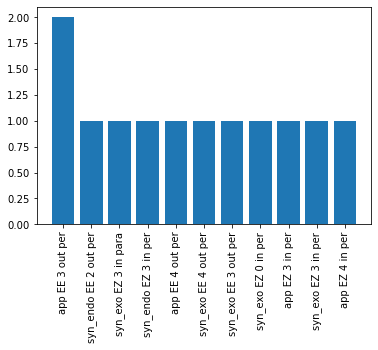

,filename,no,diene,label_dft
3,B_Me_RMe_R_63_TS,63,R,app EE 4 out per
4,B_Me_RMe_R_71_TS,71,R,syn_exo EE 4 out per
0,B_Me_RMe_R_286_TS,286,R,syn_endo EE 2 out per
1,B_Me_RMe_R_408_TS,408,R,syn_exo EZ 3 in para
2,B_Me_RMe_R_412_TS,412,R,syn_endo EZ 3 in per
5,B_Me_RMe_R_801_TS,801,R,syn_exo EE 3 out per
6,B_Me_RMe_R_802_TS,802,R,app EE 3 out per
7,B_Me_RMe_R_805_TS,805,R,app EE 3 out per
8,B_Me_RMe_R_807_TS,807,R,syn_exo EZ 0 in per
9,B_Me_RMe_R_808_TS,808,R,app EZ 3 in per


In [12]:
atom_list1=['N 3','C 6', 'C 9','O 34']
atom_list2=['C 1','C 2', 'N 3','C 6']
atom_list3=['N 3','C 6','C 8','C 11', 'C 7']
atom_list4=['C 46','C 44', 'C 6','C 9']
atom_list5=['O 34','C 9', 'C 25','C 27']
atom_list6=['O 34','C 9', 'C 25','C 26']
atom_list7=['O 34','C 9', 'C 16','C 17']
atom_list8=['O 34','C 9', 'C 16','C 18']
atom_list9=['C 54', 'C 44','C 1','C 2']


B_Me_RMe_R=category_dih_angle_noOTDS('Goodvibes_output_B_Me_RMe_R_TS.xyz', atom_list1, atom_list2, atom_list3, atom_list4, 
                   atom_list5, atom_list6,atom_list7, atom_list8, atom_list9)
B_Me_RMe_R